### Import libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedKFold
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error,r2_score

from lightgbm import LGBMRegressor

### Reading Data

In [6]:
dt = pd.read_csv(r"updated_dataset.csv", low_memory=False)
del dt['comments']

#printing summary of data
#print(round(data.describe(),2))

### DEALING MISSING VALUES

In [ ]:
# print(dt['ghi_rsi'].isnull().sum())
dt['ghi_rsi'] = dt['ghi_rsi'].fillna(dt['ghi_rsi'].mean())
dt['dhi'] = dt['dhi'].fillna(dt['dhi'].mean())
dt['dni'] = dt['dni'].fillna(dt['dni'].mean())

### Visulaizing Data Using Corealtion Matrix

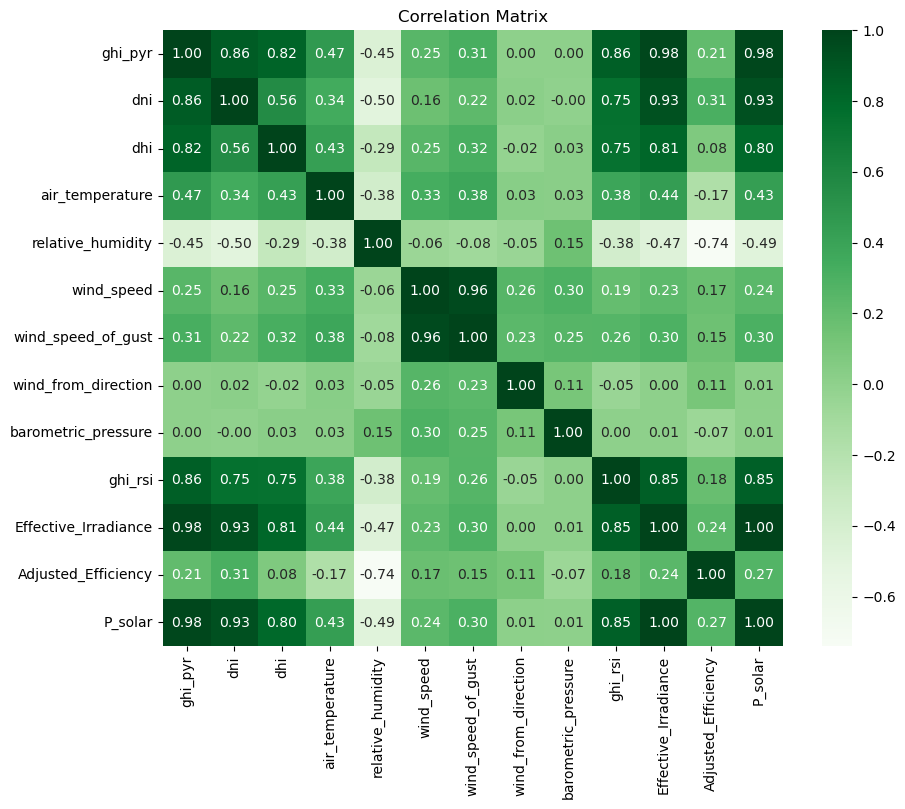

In [ ]:
columns_of_interest = [
    'ghi_pyr', 'dni', 'dhi', 'air_temperature', 'relative_humidity', 
    'wind_speed', 'wind_speed_of_gust','wind_from_direction', 'barometric_pressure', 'ghi_rsi', 'Effective_Irradiance','Adjusted_Efficiency','P_solar'
]
corr_data = dt[columns_of_interest]

# Calculating the correlation matrix
corr_matrix = corr_data.corr()
#corr_matrix.style.background_gradient(cmap='Greens').format(".2f")

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="Greens", cbar=True)
plt.title("Correlation Matrix")
plt.show()

### Feature Engineering

In [ ]:
dt['hour'] = pd.to_datetime(dt['time']).dt.hour
dt['day_of_week'] = pd.to_datetime(dt['time']).dt.dayofweek
dt['month'] = pd.to_datetime(dt['time']).dt.month
dt['season'] = dt['month'].apply(lambda x: (x % 12 + 3) // 3)  # Quarter of the year

C:\Users\talha\AppData\Local\Temp\ipykernel_1356\3570417591.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  dt['hour'] = pd.to_datetime(dt['time']).dt.hour
C:\Users\talha\AppData\Local\Temp\ipykernel_1356\3570417591.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  dt['day_of_week'] = pd.to_datetime(dt['time']).dt.dayofweek
C:\Users\talha\AppData\Local\Temp\ipykernel_1356\3570417591.py:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  dt['month'] = pd.to_datetime(dt['time']).dt.month


In [ ]:
print(dt['hour'].unique())
print(dt['month'].unique())

# Calculate the maximum value for 'hour' for normalization
max_hour_value = dt['hour'].max()
print(f"Max Hour Value: {max_hour_value}")

# Feature engineering: Create cyclic features for 'hour' and 'month'
dt['Hour_sin'] = np.sin(2 * np.pi * dt['hour'] / max_hour_value)  # Normalize 'hour' and apply sine transformation
dt['Hour_cos'] = np.cos(2 * np.pi * dt['hour'] / max_hour_value)  # Normalize 'hour' and apply cosine transformation

# For 'month', create sine and cosine features to capture the cyclical nature
dt['sine_mon'] = np.sin((dt['month'] - 1) * np.pi / 12)  # Months are cyclic
dt['cos_mon'] = np.cos((dt['month'] - 1) * np.pi / 12)   # Months are cyclic

# Check the dataframe to see the new features
print(dt.head())


columns_of_interest = [
    'ghi_pyr', 'dni', 'dhi', 'air_temperature', 'relative_humidity', 
    'wind_speed', 'wind_speed_of_gust','wind_from_direction', 'barometric_pressure', 'ghi_rsi', 'Effective_Irradiance','Adjusted_Efficiency','P_solar'
]

# Now let's create a correlation matrix and plot it using a heatmap
mask2 = np.triu(np.ones_like(dt[columns_of_interest].corr(), dtype=bool))

# Plot correlation heatmap using Spearman method
f, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(dt[columns_of_interest].corr(method='spearman'), mask=mask2, cmap='jet', vmax=.3, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.9, cbar_kws={"shrink": .5})
plt.title('Correlation analysis including encoded features for all sites')
plt.show()

Text(0.5, 1.0, 'Visualize missing values in datasets')

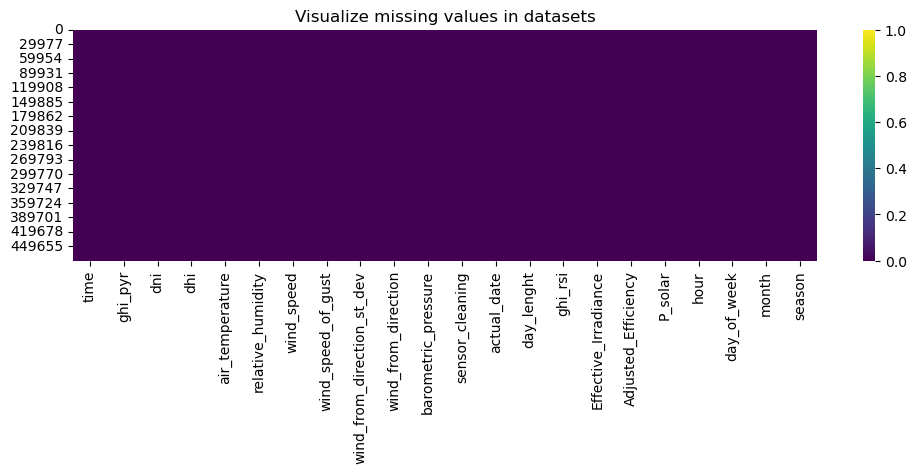

In [ ]:
plt.figure(figsize=(12, 3))
sns.heatmap(dt.isnull(), cmap='viridis')
plt.title('Visualize missing values in datasets')

### Using model

In [ ]:
X = dt.drop(['P_solar'], axis=1)
y= dt['P_solar']

### Train/test split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

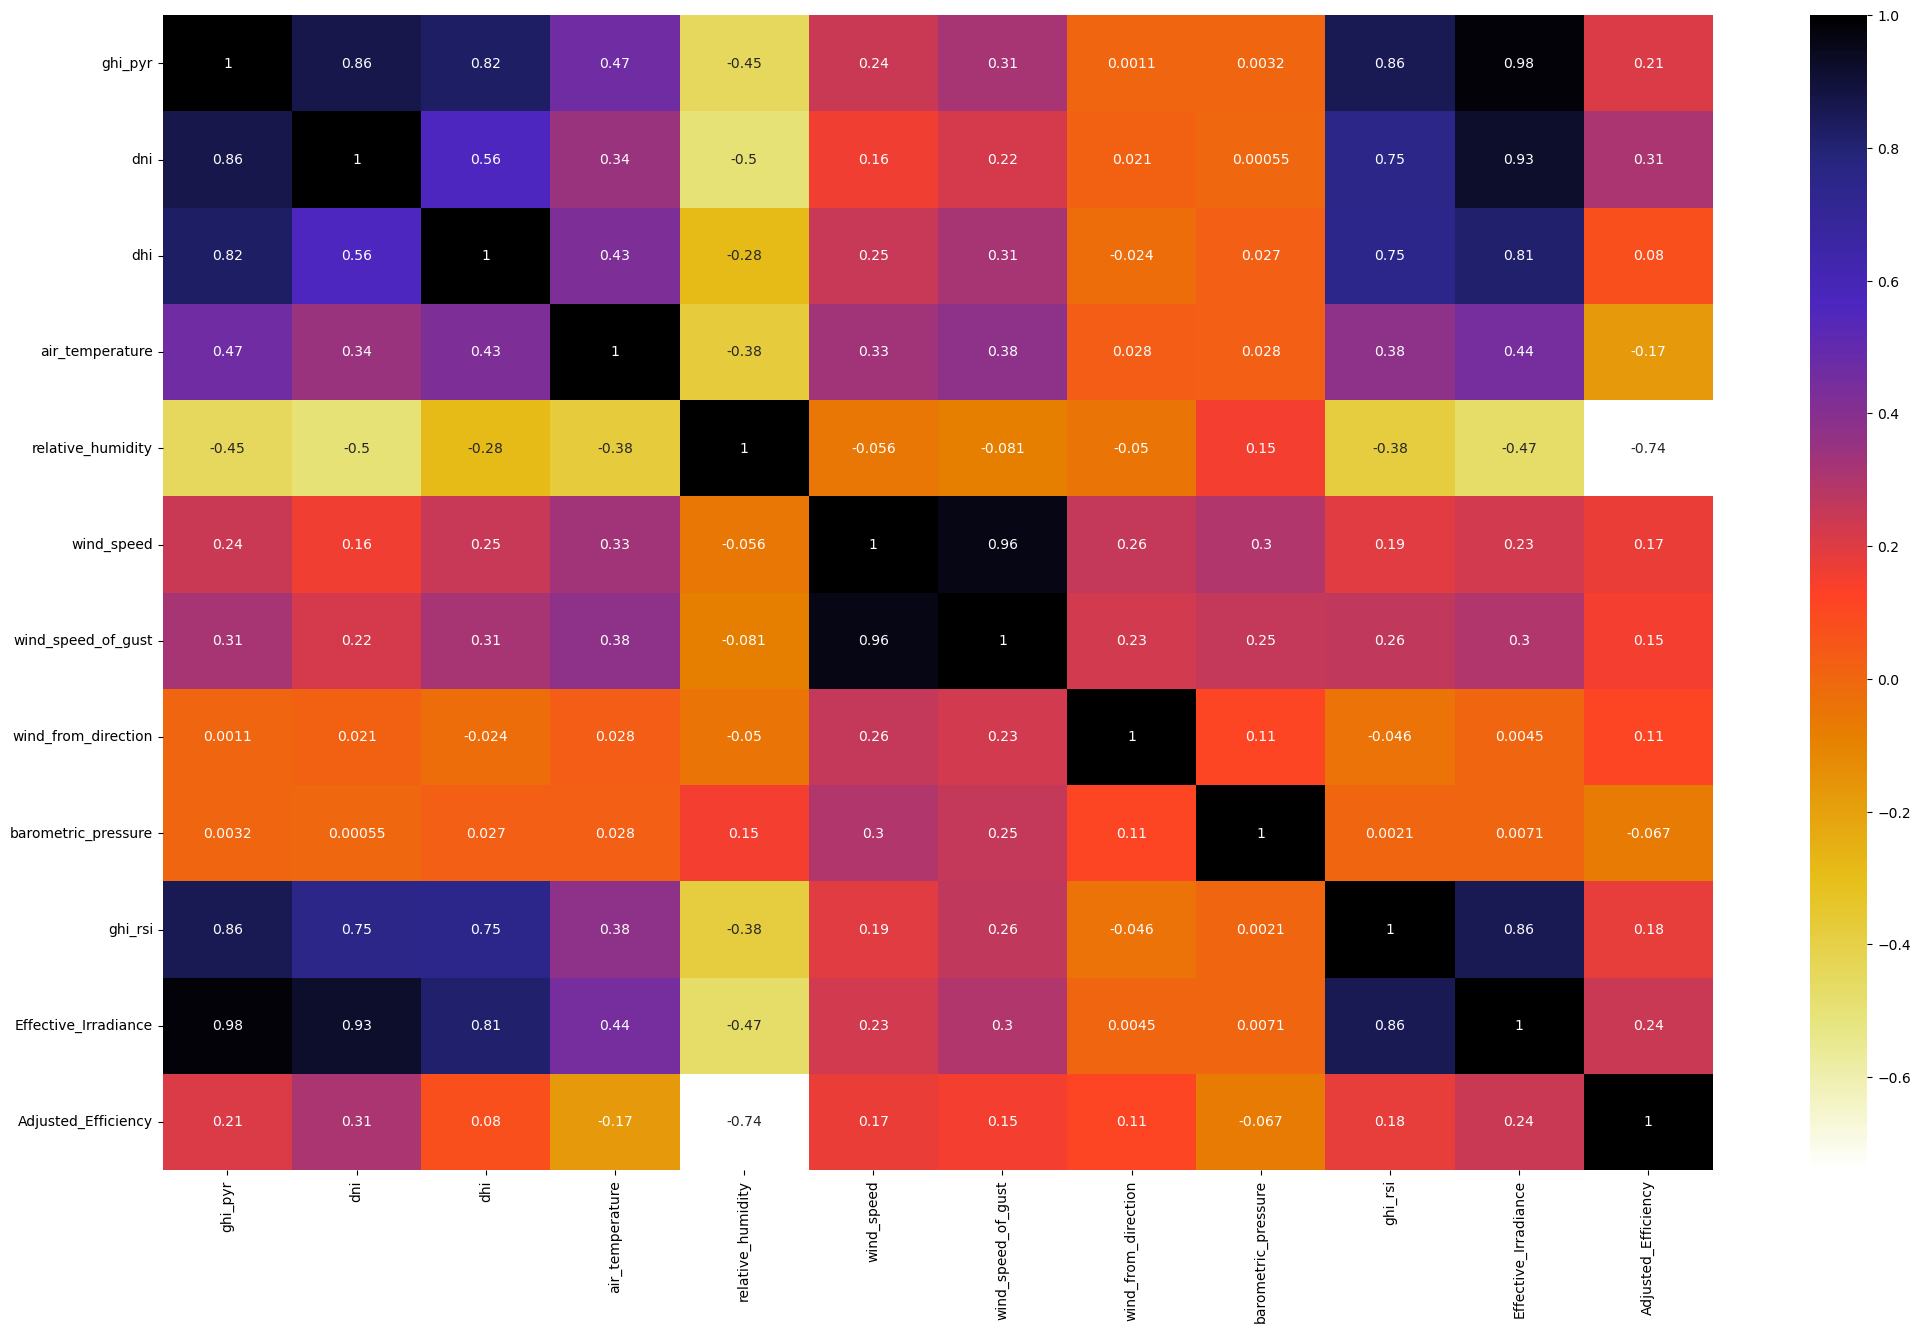

In [ ]:
plt.figure(figsize=(25,15))

columns_of_interest = [
    'ghi_pyr', 'dni', 'dhi', 'air_temperature', 'relative_humidity', 
    'wind_speed', 'wind_speed_of_gust','wind_from_direction', 'barometric_pressure', 'ghi_rsi', 'Effective_Irradiance','Adjusted_Efficiency',
]

cor=X_train[columns_of_interest].corr()
sns.heatmap(cor,annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [ ]:
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i,j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [ ]:
columns_of_interest = [
    'ghi_pyr', 'dni', 'dhi', 'air_temperature', 'relative_humidity', 
    'wind_speed', 'wind_speed_of_gust','wind_from_direction', 'barometric_pressure', 'ghi_rsi', 'Effective_Irradiance','Adjusted_Efficiency',
]

corr_features = correlation(X_train[columns_of_interest], 0.9)
len(set(corr_features))


len(set(corr_features))
corr_features

NameError: name 'X_train' is not defined